# Continous Bag of Words (CBOW)

The continous bag of words model given a context of words predicts the most likely word resulting in that context so with the example sentence:

North Korea is in peace talks with South Korea.

With a context of window size two for the word **with** the context would be **peace, talks, South, Korea**. The CBOW fits a model that will try to predict the target word based on the context supplied to it.


## Motivation

Atomic representation of words loose a lot of linguistic information. We need a representation that encapsulates context somewhat. 

The word2vec can also be interpreted as a weigh of representing words distributedly accross shared weights. This interpretation can be mapped to a neurological analogy of having different neurons activated and inhibited depending on the stimuli.

## What can it be used for?

word2vec is often used as a way to represent words which will be consumed by other deep learning models as the vector embeddings can be updated by these models to suit the task at hand.

A semantic vector space model can also be used 

### Simple one word context CBOW

![Simple one context cbow](simple_cbow.png)



Initially let's tackle a simplified version of this problem limiting the context to one word. We will encode these words through the hidden layer:
$$h=x\cdot W^T$$
Where $x$ is a one hot encoded representation (shape of 1,vocabulary_size) of our context word, $W$ is a matrix (shape of vocabulary_size, embedding_size) where each row represents a vector embedding for a word. Finally we apply another weight matrix $W'$ (shape of embedding_size, vocabulary_size) to produce a score:
$$u=h\cdot W'^T$$
Which we then transform witht the softmax function to get a posterior probability distribution:
$$y = softmax(u)$$
$y_k$ is the posterior distribution of words:
$$p(w_k|w_{input}) = y_k = \dfrac{e^{u_k}}{\sum_{i=1}^{vocabulary\_size} e^{u_i}} $$

Now let's look at a visualisation to see how this works:
[wevi demo](https://ronxin.github.io/wevi/)

In [56]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib

In [57]:
vectorizer = CountVectorizer()
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]
X = vectorizer.fit_transform(corpus)

In [58]:
test_words = corpus[0].split()
X_test_words = vectorizer.transform(test_words)
X_test_array = X_test_words.toarray()
print("This is the first document.")
print(X_test_array)

This is the first document.
[[0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]]


In [59]:
context = X_test_array[0] # This
target = X_test_array[1] # is

I have named $W=W_1$ and $W'=W_2$ in the code as I find this is a bit more intuitive

In [60]:
vocabulary_size = len(vectorizer.vocabulary_)
embedding_size = 5

np.random.seed(42)
W1 = np.random.rand(vocabulary_size, embedding_size)
W2 = np.random.rand(embedding_size, vocabulary_size)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [61]:
x = context
label = target
learning_rate = 0.1

h = np.dot(W1.T, x)
u = np.dot(W2.T, h)
y_prediction = softmax(u)

print(y_prediction)
print(y_prediction[label==1])

[0.07722179 0.16775651 0.09715749 0.11029567 0.10450131 0.07589111
 0.09979523 0.08159007 0.18579081]
[0.11029567]


### Training objective

For one sample our training objective is to maximise the probability of observing the target word given the input word $w_{input}$:
$$max(p(w_{target}|w_{input}) = max(y_{k*})$$
$$ = max(log(y_{k*}))$$
$$ = max(log(\dfrac{e^{u_k*}}{\sum_{i=1}^{vocabulary\_size} e^{u_i}}))$$

#### Loss function

As such we can define our loss function as:
$$E(u_{k*}) = -log(\dfrac{e^{u_{k*}}}{\sum_{i=1}^{vocabulary\_size} e^{u_i}})$$
$$E = -log(softmax) $$

Where $k*$ represents the index in the output layer for $w_target$


#### Derivative of the loss function

Now let's derive the derivative of the loss function with regards to the ${k*}$th unit's net input $u_{k*}$: $\dfrac{\delta E}{\delta u_{k*}}$

With $softmax(u_j) = \dfrac{e^{u_j}}{\sum_{i=1}^{vocabulary\_size} e^{u_i}}$

First of all let's subsitute the sum from the $softmax$ function:

$$\sigma = {\sum_{i=1}^{vocabulary\_size} e^{u_i}}$$

For $u_j = u_{k*}$ we can use the quotient rule $f(x) = g(x)/h(x)$ => $f'(x) = \dfrac{g'(x)h(x)-g(x)h'(x)}{[h(x)]^2]}$:

$$ \dfrac{\delta softmax}{\delta u_{k*}} = \dfrac{e^{u_j}\sigma - e^{2u_j}}{\sigma^2}$$

For $u_j \neq u_{k*} $ then $e^{u_j}$ is treated as a constant:

$$ \dfrac{\delta softmax}{\delta u_{k*}} = \dfrac{-e^{u_j} e^{u_k*}}{\sigma^2} $$

Now that we are done bottom up let's look at the derivative top down:

$$ \dfrac{\delta E}{\delta softmax} = -(\dfrac{1}{softmax(u_{k*})})$$

Using the chain rule:

$$ \dfrac{\delta E}{\delta u_{k*}} = - \dfrac{1}{\dfrac{e^{u_j}}{\sigma}} \dfrac{\delta softmax}{\delta u_{k*}} = -\dfrac{\sigma}{e^{u_j}} \dfrac{\delta softmax}{\delta u_{k*}}$$

Considering $u_j$ and $u_{k*}$ if $u_j = u_{k*}$:

$$ \dfrac{\delta E}{\delta u_{k*}} = \dfrac{e^{u_{k*}} - \sigma}{\sigma} = \dfrac{e^{u_{k*}}}{\sigma} - 1 = softmax -1 $$

And for $u_j \neq u_{k*}$:

$$ \dfrac{\delta E}{\delta u_{k*}} = \dfrac{e^{u_{k*}}}{\sigma} = softmax$$

These two equations can be combined using the Kronecker delta, which is a function that produces one if the two variables are equalo otherwise 0:

$$ \dfrac{\delta E}{\delta u_{k*}} = softmax - \delta_{jk*} $$

The Kronecker delta is the same here as our one hot vector labels as they will only be 1 at the index $k*$ as such this is the same as the prediction error $e_k*$ of the output layer:

$$ y_{k*} - target $$

I won't derive the rest of the derivatives but after this bit you just need to continue moving down the layers to derive $\dfrac{\delta E}{\delta W'}$ and $\dfrac{\delta E}{\delta W}$

For $\dfrac{\delta E}{\delta W'}$ based on the above derived derivative E with respect to the output of the output layer we need to take the derivative of the output layer with regards to W'.

For $\dfrac{\delta E}{\delta W}$:
You need to take the derivative of E with regards to the output of the hidden layer and then the derivative of the hidden layer with regards to W. 


In [62]:
e = y_prediction - label 
dW2 = np.outer(h, e)
dW1 = np.outer(x, np.dot(W2, e)) # np.dot(W2, e) is the sum of all output vectors
                                # weighted by their prediction error

new_W1 = W1 - learning_rate * dW1
new_W2 = W2 - learning_rate * dW2

W1 = new_W1
W2 = new_W2

In [63]:
x = context
label = target
learning_rate = 0.1

h = np.dot(W1.T, x)
u = np.dot(W2.T, h)
y_prediction = softmax(u)

print("softmax output:", y_prediction)
print("target_probability:",y_prediction[label==1])
e = y_prediction - label
loss = e[label==1]
print("loss:",e[label==1])

softmax output: [0.07561359 0.16460368 0.09768569 0.12485411 0.10430454 0.0752792
 0.09666628 0.07926576 0.18172715]
target_probability: [0.12485411]
loss: [-0.87514589]


In [72]:
def cbow_train(context, target, W1, W2, learning_rate = 0.1):
    x = context
    label = target

    h = np.dot(W1.T, x)
    u = np.dot(W2.T, h)
    y_prediction = softmax(u)

    print("softmax output:", y_prediction)
    print("target_probability:",y_prediction[label==1])
    e = y_prediction - label
    loss = -e[label==1]
    print("loss:",e[label==1])
    dW2 = np.outer(h, e)
    dW1 = np.outer(x, np.dot(W2, e)) # np.dot(W2, e) is a vector of all output vectors
                                    # weighted by their prediction error

    new_W1 = W1 - learning_rate * dW1
    new_W2 = W2 - learning_rate * dW2

    return new_W1, new_W2, loss
    
def cbow_predict(context, target, W1, W2, learning_rate = 0.1):
    x = context
    label = target

    h = np.dot(W1.T, x)
    u = np.dot(W2.T, h)
    y_prediction = softmax(u)

    print("softmax output:", y_prediction)
    print("target_probability:",y_prediction[label==1])

In [73]:
losses = []
for i in range(5):
    for k in range(len(test_words)):
        context = X_test_array[k]
        try:
            target = X_test_array[k+1]
        except IndexError:
            break
        W1, W2, loss = cbow_train(context, target, W1, W2, learning_rate = 0.1)
        losses.append(loss)
            
    print("end loop")

softmax output: [0.03648628 0.13501279 0.21727725 0.32866004 0.06141817 0.04080194
 0.05002724 0.03227341 0.09804288]
target_probability: [0.32866004]
loss: [-0.67133996]
softmax output: [0.05928928 0.13348921 0.12995741 0.05617348 0.07371903 0.04959353
 0.33687702 0.10259402 0.05830701]
target_probability: [0.33687702]
loss: [-0.66312298]
softmax output: [0.03222323 0.04765932 0.36232103 0.21628521 0.05107822 0.04622685
 0.12251876 0.05453912 0.06714825]
target_probability: [0.36232103]
loss: [-0.63767897]
softmax output: [0.04225933 0.58667939 0.03610786 0.06233727 0.03739199 0.02272349
 0.12364547 0.03241885 0.05643636]
target_probability: [0.58667939]
loss: [-0.41332061]
end loop
softmax output: [0.03272583 0.12567781 0.22419469 0.36357214 0.05602717 0.03687682
 0.04275153 0.02833876 0.08983526]
target_probability: [0.36357214]
loss: [-0.63642786]
softmax output: [0.05453304 0.12842343 0.12817238 0.04800672 0.06792433 0.04533907
 0.37855792 0.09700737 0.05203575]
target_probability

In [69]:
list(range(len(test_words)))

[0, 1, 2, 3, 4]

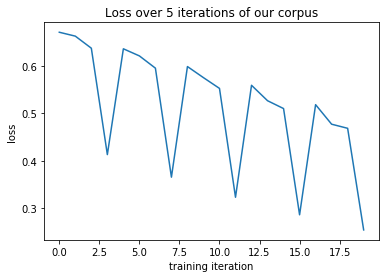

In [74]:
import matplotlib.pyplot as plt
x = list(range(len(losses)))
y = losses

plt.plot(x,y)
plt.xlabel('training iteration')
plt.ylabel('loss')
plt.title("Loss over 5 iterations of our corpus")
plt.show()

### Questions

Okay so how do make predictions based on a longer context?

### Skipgram model

In a skipgram model we output multiple categorical distributions. The skipgram model based on an input word predicts a potential context words around it.



## Document clustering

In [100]:
from sklearn.decomposition import PCA

X1 = PCA(n_components=2).fit_transform(np.dot(X_test_array,W1))
X2 = PCA(n_components=2).fit_transform(np.dot(np.dot(X_test_array,W1),W2))

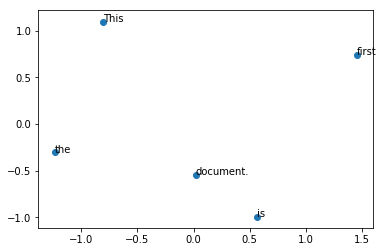

In [101]:
fig, ax = plt.subplots()
ax.scatter(X1[:,0], X1[:,1])

for i, txt in enumerate(test_words):
    ax.annotate(txt, (X1[i,0],X[i,1]))

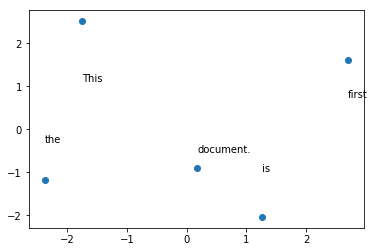

In [102]:
fig, ax = plt.subplots()
ax.scatter(X2[:,0], X2[:,1])

for i, txt in enumerate(test_words):
    ax.annotate(txt, (X2[i,0],X[i,1]))

References:

Xin Rong, word2vec Parameter Learning Explained [arXiv:1411.2738v4](https://arxiv.org/abs/1411.2738v4)  
Xin Rong, Word Embedding Explained and Visualized - word2vec and wevi https://www.youtube.com/watch?v=D-ekE-Wlcds&feature=youtu.be  
Xin Rong, [wevi](https://ronxin.github.io/wevi/)